<a href="https://colab.research.google.com/github/andssuu/redes_neurais_pos/blob/main/projeto/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/andssuu/redes_neurais_pos.git

Cloning into 'redes_neurais_pos'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 165 (delta 48), reused 41 (delta 8), pack-reused 0
Receiving objects: 100% (165/165), 18.49 MiB | 28.82 MiB/s, done.
Resolving deltas: 100% (48/48), done.


# Projeto Redes Neurais

O projeto consiste no desenvolvimento de um modelo para detecção de comportamentos do gado leiteiro por meio de dados de sensores (acelerômetro, giroscópio, magnetômetro e GPS) embutidos em uma coleira.

Comportamentos como andar, pastar, deitar e ócio são interessantes para otimização de recursos no manejo dos animais. Dentre tais informações de comportamento, é possível destacar a ruminação do animal na detecção de doenças e no cio. Portanto, monitorar os comportamentos dos animais é uma tarefa muito importante para ajudar o produtor numa melhor tomada de decisão.

Para realizar tal tarefa, este trabalho tem como objetivo avaliar a utilização de uma rede MultiLayer Perceptron (MLP) aplicando algumas técnicas de otimização. Comparações em relação à acurácia também foram realizadas.  


# Base de Dados

* 2 períodos: primeiro de 25/03/15 a 30/03/15 e de 06/04/15 a 09/04/15
* 4 animais (3 distintos)
* Foram utilizadas 4 coleiras (A, B, C e D). Entretanto, houve algumas falhas durante o experimento e, no final, ficaram as seguintes bases:
  - A2 e A3
  - B2 e B3
  - C3 e C4
  - D1, D2, D3 e D4

O arquivo lomba.csv contém todos os dados aglutinados que foram utilizados. A estrutura de cabeçalho é definida da seguinte forma:

IdColar | AccX | AccY | AccZ | MagX | MagY | MagZ | GirX | GirY | GirZ | Horario | Data | VelocidadeDeslocamento | Comportamento 
 --- | --- | --- |--- |--- |--- |--- |--- |--- |--- |--- |---|---|---
A2 | -11889 | 11184 | -17877 | -1280 | -73 | -309 | -4013 | 1260 | -31 | 131911.203 | 250515 | 000.0 | Comendo/Procurando
A2 | -9144 | 8945 | -11799 | -1213 | 707 | -238 | -394 | 2278 | -602 | 131949.203 | 250515 | 000.0 | Comendo/Procurando
A2 | 6391 | 9265 | -11767 | 570 | -405 | -1533 | -1072 | -1094 | 1854 | 132148.203 | 250515 | 000.0 | EmPe
A2 | -1394 | 10206 | -13229 | 671 | -73 | -1590 | 287 | 2253 | -2760 | 132151.203 | 250515 | 000.0 | Comendo/Procurando
...| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... 
D4 | 2152 | 7619 | -7736 | -1650 | 788 | 43 | -2980 | 3678 | -1357 | 122529.111 | 040715 | 000.0 | Comendo/Procurando


No total há 13088 amostras. A tabela a seguir mostra a segmentação das amostras por coleira

A2 | A3 | B2 | B3 | C3 | C4 | D1 | D2 | D3 | D4 | Total
--- | --- | --- |--- |--- |--- |--- |--- |--- |--- |--- | 
1112 | 2033 | 1131 | 1735 | 1852 | 406 | 1126 | 1690 | 1598 | 405 | 13088


# Visualização dos dados


In [4]:
import operator
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


warnings.filterwarnings("ignore")
df = pd.read_csv('redes_neurais_pos/projeto/data/lomba.csv')
data = df[df.columns[1:10]]
data_normalized = (data - data.min()) / (data.max() - data.min())
labels = df[df.columns[-1]]
le = preprocessing.LabelEncoder()
le.fit(labels.values)
labels = le.transform(labels.values)
data.head()

,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,giro_x,giro_y,giro_z
0,-11889,11184,-17877,-1280,-73,-309,-4013,1260,-31
1,-9144,8945,-11799,-1213,707,-238,-394,2278,-602
2,6391,9265,-11767,570,-405,-1533,-1072,-1094,1854
3,-1394,10206,-13229,671,-73,-1590,287,2253,-2760
4,-4864,5953,-10472,-84,-200,-1767,-7101,9206,-3595


In [8]:
data_normalized.head()

,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z,giro_x,giro_y,giro_z
0,0.334605,0.661770,0.244090,0.173799,0.335664,0.439289,0.418168,0.451028,0.499557
1,0.378613,0.626671,0.345635,0.191389,0.523752,0.460681,0.475423,0.468785,0.490844
2,0.627671,0.631688,0.346170,0.659491,0.255606,0.070503,0.464696,0.409967,0.528322
3,0.502862,0.646439,0.321744,0.686007,0.335664,0.053329,0.486197,0.468349,0.457914
4,0.447230,0.579768,0.367806,0.487792,0.305040,0.000000,0.369314,0.589632,0.445172


In [9]:
d= data_normalized.iloc[:, 0]
print("{}, {}".format(np.mean(d), np.std(d)))

0.5449583702858021, 0.0987396380250551


[5732, 3736, 2391, 1229]

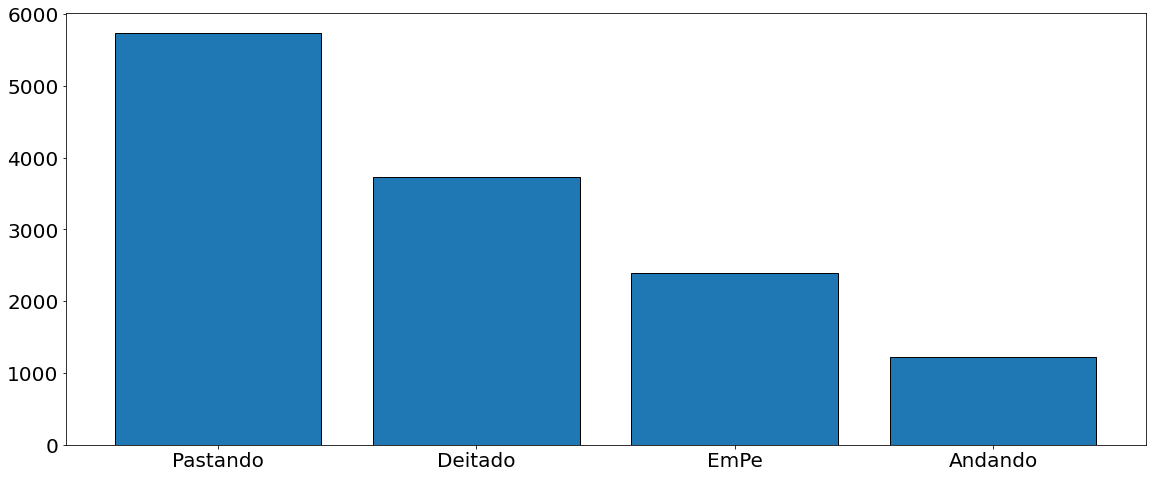

In [17]:
fig = plt.figure(figsize=(15, 6))
plt.rcParams.update({'font.size': 20})
ax = fig.add_axes([0,1,1,1])
comportamentos = list(set(df.comportamento.values))
#ax.set_title('Distribuição dos dados por classe', fontsize=30)
count_list = [sum(df.comportamento==comportamento) for comportamento in comportamentos]
ax.bar(comportamentos, count_list, edgecolor='black')
count_list


## Notebooks Sensores

* [Acelerômetro](https://colab.research.google.com/github/andssuu/moncattle/blob/master/visualization/notebooks/accelerometer.ipynb)

* [Giroscópio](https://colab.research.google.com/github/andssuu/moncattle/blob/master/visualization/notebooks/gyroscope.ipynb)

* [Magnetômetro](https://colab.research.google.com/github/andssuu/moncattle/blob/master/visualization/notebooks/magnetometer.ipynb)


# Arquitetura

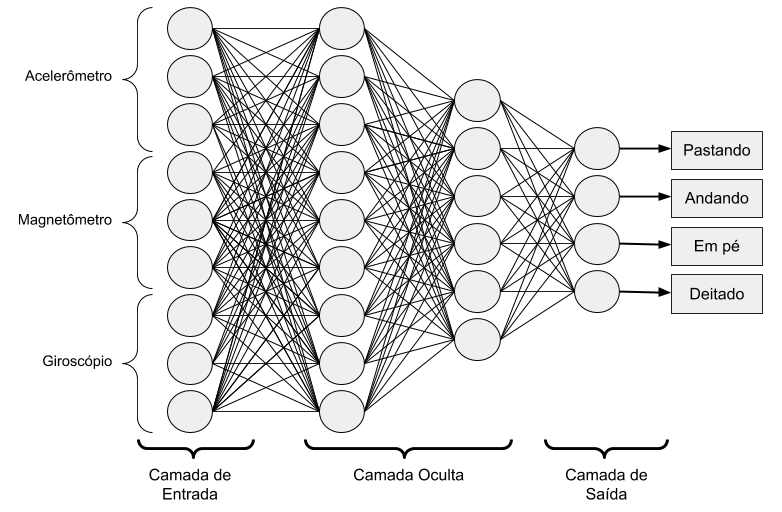


## Validação

Para validação, foi utilizada a técnica de validação cruzada com o valor do k igual a 10. A figura abaixo ilustra a divisão dos dados para essa abordagem. O valor da acurácia média foi utilizado como medida de avaliação para obter o melhor conjunto de valores para os parâmetros da rede.

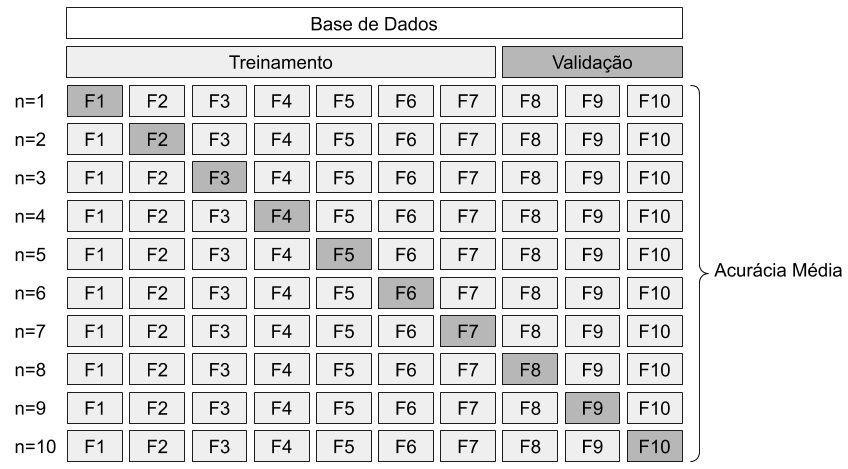




# Otimizações

*   L2
*   Momentum


In [1]:
class Score():
    def __init__(self, mean, std, learning_rate, hidden_layer_1, 
                 hidden_layer_2):
        self.mean = mean
        self.std = std
        self.learning_rate = learning_rate
        self.hidden_layer_1 = hidden_layer_1
        self.hidden_layer_2 = hidden_layer_2

    def __repr__(self):
        return "Mean: {}, Std: {}, Learning Rate: {}, Camada Oculta: [{}, {}]".\
        format(self.mean, self.std, self.learning_rate, self.hidden_layer_1, 
               self.hidden_layer_2)

outputs = []
for learning_rate in [0.3]:
    # for hidden_layer_1 in [9, 18, 27, 36]:
    for hidden_layer_1 in [36]:
        hidden_layer_2 = int(np.sqrt(hidden_layer_1*4))
        print("Taxa de Aprendizagem: {}, Camada Oculta: [{}]".format(
            learning_rate, hidden_layer_1))
        clf = MLPClassifier(solver='lbfgs', activation='logistic',
                            hidden_layer_sizes=(hidden_layer_1,),
                            batch_size=24, learning_rate_init=learning_rate,
                            shuffle=True, alpha=0)
        scores = cross_val_score(clf, data_normalized, labels, cv=10)
        [print("{}-Fold: {:.2f}".format(k, score)) for k, score in enumerate(
            scores, 1)]
        mean = np.mean(scores)
        std = np.std(scores)
        outputs.append(Score(mean, std, learning_rate, hidden_layer_1,
                             hidden_layer_2))
        print("\tAcurácia média: {:.2f}".format(mean))
        print("\tDesvio Padrão: {:}".format(std))
best = sorted(outputs, key=operator.attrgetter("mean"), reverse=True)
print(best)

NameError: ignored

In [27]:
class Score():
    def __init__(self, mean, std, learning_rate, hidden_layer_1, 
                 hidden_layer_2):
        self.mean = mean
        self.std = std
        self.learning_rate = learning_rate
        self.hidden_layer_1 = hidden_layer_1
        self.hidden_layer_2 = hidden_layer_2

    def __repr__(self):
        return "Mean: {}, Std: {}, Learning Rate: {}, Camada Oculta: [{}, {}]".\
        format(self.mean, self.std, self.learning_rate, self.hidden_layer_1, 
               self.hidden_layer_2)

outputs = []
for learning_rate in [0.3]:
    # for hidden_layer_1 in [9, 18, 27, 36]:
    for hidden_layer_1 in [36]:
        hidden_layer_2 = int(np.sqrt(hidden_layer_1*4))
        print("Taxa de Aprendizagem: {}, Camada Oculta: [{}]".format(
            learning_rate, hidden_layer_1))
        skf = StratifiedKFold(n_splits=10)
        clf = MLPClassifier(solver='lbfgs', activation='logistic',
                            hidden_layer_sizes=(hidden_layer_1,),
                            batch_size=24, learning_rate_init=learning_rate,
                            early_stopping=True)
        scores = cross_val_score(clf, data_normalized, labels, cv=skf)
        [print("{}-Fold: {:.2f}".format(k, score)) for k, score in enumerate(
            scores, 1)]
        mean = np.mean(scores)
        std = np.std(scores)
        outputs.append(Score(mean, std, learning_rate, hidden_layer_1,
                             hidden_layer_2))
        print("\tAcurácia média: {:.2f}".format(mean))
        print("\tDesvio Padrão: {:}".format(std))
best = sorted(outputs, key=operator.attrgetter("mean"), reverse=True)
print(best)

Taxa de Aprendizagem: 0.3, Camada Oculta: [36]
1-Fold: 0.59
2-Fold: 0.59
3-Fold: 0.69
4-Fold: 0.75
5-Fold: 0.81
6-Fold: 0.69
7-Fold: 0.83
8-Fold: 0.64
9-Fold: 0.77
10-Fold: 0.78
	Acurácia média: 0.71
	Desvio Padrão: 0.08214029039101116
[Mean: 0.7147094450791158, Std: 0.08214029039101116, Learning Rate: 0.3, Camada Oculta: [36, 12]]


In [24]:
class Score():
    def __init__(self, mean, std, learning_rate, hidden_layer_1, 
                 hidden_layer_2):
        self.mean = mean
        self.std = std
        self.learning_rate = learning_rate
        self.hidden_layer_1 = hidden_layer_1
        self.hidden_layer_2 = hidden_layer_2

    def __repr__(self):
        return "Mean: {}, Std: {}, Learning Rate: {}, Camada Oculta: [{}, {}]".\
        format(self.mean, self.std, self.learning_rate, self.hidden_layer_1, 
               self.hidden_layer_2)

outputs = []
for learning_rate in [0.3]:
    # for hidden_layer_1 in [9, 18, 27, 36]:
    for hidden_layer_1 in [36]:
        hidden_layer_2 = int(np.sqrt(hidden_layer_1*4))
        print("Taxa de Aprendizagem: {}, Camada Oculta: [{}]".format(
            learning_rate, hidden_layer_1))
        skf = StratifiedKFold(n_splits=10)
        clf = MLPClassifier(solver='lbfgs', activation='relu',
                            hidden_layer_sizes=(hidden_layer_1,),
                            batch_size=24, learning_rate_init=learning_rate,
                            early_stopping=True)
        scores = cross_val_score(clf, data_normalized, labels, cv=skf)
        [print("{}-Fold: {:.2f}".format(k, score)) for k, score in enumerate(
            scores, 1)]
        mean = np.mean(scores)
        std = np.std(scores)
        outputs.append(Score(mean, std, learning_rate, hidden_layer_1,
                             hidden_layer_2))
        print("\tAcurácia média: {:.2f}".format(mean))
        print("\tDesvio Padrão: {:}".format(std))
best = sorted(outputs, key=operator.attrgetter("mean"), reverse=True)
print(best)

Taxa de Aprendizagem: 0.3, Camada Oculta: [36]
1-Fold: 0.68
2-Fold: 0.60
3-Fold: 0.66
4-Fold: 0.75
5-Fold: 0.76
6-Fold: 0.65
7-Fold: 0.80
8-Fold: 0.59
9-Fold: 0.76
10-Fold: 0.79
	Acurácia média: 0.70
	Desvio Padrão: 0.07347319299395202
[Mean: 0.7037092067852997, Std: 0.07347319299395202, Learning Rate: 0.3, Camada Oculta: [36, 12]]


In [20]:
labels

array([3, 3, 2, ..., 3, 3, 3])

In [19]:
class Score():
    def __init__(self, mean, std, learning_rate, hidden_layer_1, 
                 hidden_layer_2):
        self.mean = mean
        self.std = std
        self.learning_rate = learning_rate
        self.hidden_layer_1 = hidden_layer_1
        self.hidden_layer_2 = hidden_layer_2

    def __repr__(self):
        return "Mean: {}, Std: {}, Learning Rate: {}, Camada Oculta: [{}, {}]".\
        format(self.mean, self.std, self.learning_rate, self.hidden_layer_1, 
               self.hidden_layer_2)

outputs = []
for learning_rate in [0.3]:
    # for hidden_layer_1 in [9, 18, 27, 36]:
    for hidden_layer_1 in [36]:
        hidden_layer_2 = int(np.sqrt(hidden_layer_1*4))
        print("Taxa de Aprendizagem: {}, Camada Oculta: [{}]".format(
            learning_rate, hidden_layer_1))
        skf = StratifiedKFold(n_splits=10)
        clf = MLPClassifier(solver='sgd', activation='tanh',
                            hidden_layer_sizes=(hidden_layer_1,),
                            batch_size=24, learning_rate_init=learning_rate,
                            early_stopping=True)
        scores = cross_val_score(clf, data_normalized, labels, cv=skf)
        [print("{}-Fold: {:.2f}".format(k, score)) for k, score in enumerate(
            scores, 1)]
        mean = np.mean(scores)
        std = np.std(scores)
        outputs.append(Score(mean, std, learning_rate, hidden_layer_1,
                             hidden_layer_2))
        print("\tAcurácia média: {:.2f}".format(mean))
        print("\tDesvio Padrão: {:}".format(std))
best = sorted(outputs, key=operator.attrgetter("mean"), reverse=True)
print(best)

Taxa de Aprendizagem: 0.3, Camada Oculta: [36]
1-Fold: 0.63
2-Fold: 0.65
3-Fold: 0.77
4-Fold: 0.73
5-Fold: 0.80
6-Fold: 0.69
7-Fold: 0.82
8-Fold: 0.65
9-Fold: 0.73
10-Fold: 0.77
	Acurácia média: 0.72
	Desvio Padrão: 0.06241985500594053
[Mean: 0.7235673168349909, Std: 0.06241985500594053, Learning Rate: 0.3, Camada Oculta: [36, 12]]


# Resultados

Taxa de Aprendizagem | L2 | Momentum | Acurácia 
 --- | --- | --- |--- 
? | ? | ? | ? 
? | ? | ? | ? 
? | ? | ? | ? 
? | ? | ? | ? 
? | ? | ? | ? 
? | ? | ? | ? 
? | ? | ? | ? 
? | ? | ? | ? 
? | ? | ? | ? 
? | ? | ? | ? 


#Trabalhos Futuros




*   Aplicar um pré-processamento nos dados (filtros passa alta/baixa)
*   Aumentar a quantidade de épocas no treinamento
*   Avaliar outras topologias na camada oculta
*   Utilizar uma abordagem evolucionária para obter os melhores parâmetros da rede
*   Testar outros algoritmos além do gradiente descendente como o LBFGS e ADAM
*   Utilizar outras funções de ativação como por exemplo a tangente hiperbólica, Relu, Elu e entre outras
